# $XX$ all-to-all Ising interactions


In [54]:
import itertools
import jax 
import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.ops.base import SharedGate
from squint.ops.dv import DiscreteVariableState, HGate, RZGate, RXXGate
from squint.utils import partition_op

In [55]:
dim = 2
n = 4

circuit = Circuit(backend='pure')

for i in range(n):
    circuit.add(DiscreteVariableState(wires=(i,), n=(0,)))

for i in range(n):
    circuit.add(HGate(wires=(i,)))

for i, j in itertools.combinations(list(range(n)), 2):
    circuit.add(RXXGate(wires=(i, j), angle=jnp.pi / 2))

circuit.add(
    SharedGate(op=RZGate(wires=(0,), phi=0.1 * jnp.pi), wires=tuple(range(1, n))),
    "phase",
)

for i in range(n):
    circuit.add(HGate(wires=(i,)))

pprint(circuit)

Circuit(
  dims=None,
  ops={
│   0:
│   DiscreteVariableState(wires=(0,), n=[(1.0, (0,))]),
│   1:
│   DiscreteVariableState(wires=(1,), n=[(1.0, (0,))]),
│   2:
│   DiscreteVariableState(wires=(2,), n=[(1.0, (0,))]),
│   3:
│   DiscreteVariableState(wires=(3,), n=[(1.0, (0,))]),
│   4:
│   HGate(wires=(0,)),
│   5:
│   HGate(wires=(1,)),
│   6:
│   HGate(wires=(2,)),
│   7:
│   HGate(wires=(3,)),
│   8:
│   RXXGate(wires=(0, 1), angles=weak_f64[], _basis_op_indices=(2, 2)),
│   9:
│   RXXGate(wires=(0, 2), angles=weak_f64[], _basis_op_indices=(2, 2)),
│   10:
│   RXXGate(wires=(0, 3), angles=weak_f64[], _basis_op_indices=(2, 2)),
│   11:
│   RXXGate(wires=(1, 2), angles=weak_f64[], _basis_op_indices=(2, 2)),
│   12:
│   RXXGate(wires=(1, 3), angles=weak_f64[], _basis_op_indices=(2, 2)),
│   13:
│   RXXGate(wires=(2, 3), angles=weak_f64[], _basis_op_indices=(2, 2)),
│   'phase':
│   SharedGate(
│     wires=(0, 1, 2, 3),
│     op=RZGate(wires=(0,), phi=weak_f64[]),
│     copies=[
│   │   RZGate(wires=(1,), phi=None),
│   │   RZGate(wires=(2,), phi=None),
│   │   RZGate(wires=(3,), phi=None)
│     ],
│     where=<function <lambda>>,
│     get=<function <lambda>>
│   ),
│   15:
│   HGate(wires=(0,)),
│   16:
│   HGate(wires=(1,)),
│   17:
│   HGate(wires=(2,)),
│   18:
│   HGate(wires=(3,))
  },
  _backend='pure'
)

In [56]:
params, static = partition_op(circuit, "phase")
# params, static = eqx.partition(circuit, eqx.is_inexact_array)
sim = circuit.compile(params, static, dim=dim, optimize="greedy").jit()
get = lambda pytree: jnp.array([pytree.ops["phase"].op.phi])

In [57]:
prob = sim.probabilities.forward(params)
dprob = sim.probabilities.grad(params)
cfi = jnp.sum(get(dprob) ** 2 / (prob + 1e-14))

print(f"CFI is {cfi}")

CFI is 3.9999979925098375


In [58]:
phis = jnp.linspace(-jnp.pi, jnp.pi, 100)

def update(phi, params):
    return eqx.tree_at(lambda pytree: pytree.ops["phase"].op.phi, params, phi)
    
probs = jax.lax.map(lambda phi: sim.probabilities.forward(update(phi, params)), phis)
qfims = jax.lax.map(lambda phi: sim.amplitudes.qfim(get, update(phi, params)), phis)
cfims = jax.lax.map(lambda phi: sim.probabilities.cfim(get, update(phi, params)), phis)

[Text(0.5, 0, 'Phase, $\\varphi$'),
 Text(0, 0.5, '$\\mathcal{I}_\\varphi^C$'),
 (0.0, 4.199999459342314)]

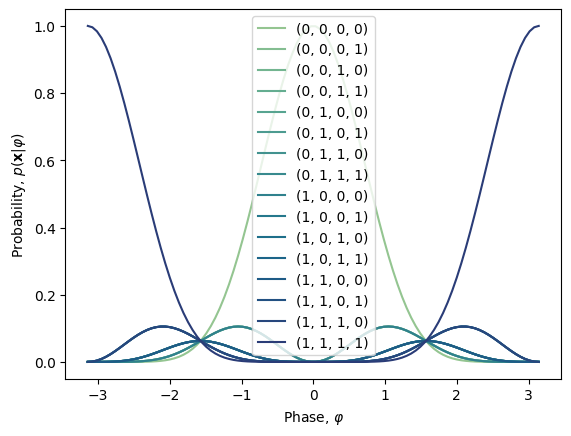

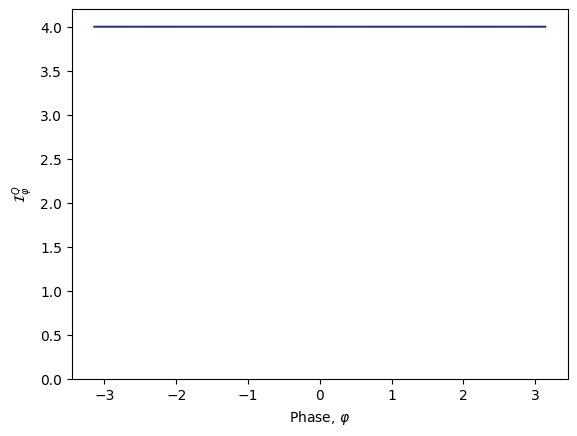

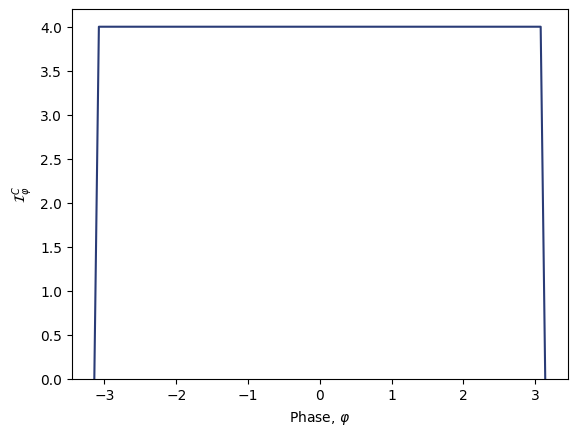

In [59]:
colors = sns.color_palette("crest", n_colors=jnp.prod(jnp.array(probs.shape[1:])))
fig, ax = plt.subplots()
for i, idx in enumerate(
    itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
):
    ax.plot(phis, probs[:, *idx], label=f"{idx}", color=colors[i])
ax.legend()
ax.set(xlabel=r"Phase, $\varphi$", ylabel=r"Probability, $p(\mathbf{x} | \varphi)$")


fig, ax = plt.subplots()
ax.plot(phis, qfims.squeeze(), color=colors[i])
ax.set(
    xlabel=r"Phase, $\varphi$",
    ylabel=r"$\mathcal{I}_\varphi^Q$",
    ylim=[0, 1.05 * jnp.max(qfims)],
)

fig, ax = plt.subplots()
ax.plot(phis, cfims.squeeze(), color=colors[i])
ax.set(
    xlabel=r"Phase, $\varphi$",
    ylabel=r"$\mathcal{I}_\varphi^C$",
    ylim=[0, 1.05 * jnp.max(cfims)],
)